In [639]:
from base_dataset import BaseDataset
import random
from torchvision import transforms
import numpy as np
from PIL import Image
import cv2

from util import gen_trimap, gen_trimap_with_dilate, gen_trimap_with_dilate_bbox

In [640]:
# root_dir = '/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation'
# ds = BaseDataset(root_dir, img_dir="images", alpha_dir="masks")

In [641]:
# ds = BaseDataset( "/home/ubuntu/data/yong/projects/MODNet/data/PPM-100",
#         "image",
#         "matte")

In [642]:
# ds = BaseDataset( "/home/ubuntu/data/yong/projects/P3M/data/P3M-10k/train",
#         "blurred_image",
#         "mask")

In [1038]:
ds = BaseDataset( "/home/ubuntu/data/yong/dataset/Human-Segmentation-Dataset",
        "Training_Images",
        "Ground_Truth")

290 samples


In [1039]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/human_matting_dataset_kaggle",
#         "JPEGImages",
#         "SegmentationClassPNG")

In [1040]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/segmentation_full_body_mads_dataset_1192_img",
#         "images",
#         "masks")

In [1041]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/RealWorldPortrait-636",
#         "image",
#         "alpha")

In [1042]:
# ds = BaseDataset("/home/ubuntu/data/yong/dataset/people_segmentation",
#         "images",
#         "profiles")

In [1043]:
rand_idx = random.randint(0, len(ds) - 1)
sample = ds[rand_idx]

In [1044]:
alpha_path, weight, img, trimap, alpha = sample

In [1045]:
alpha = np.array(Image.open(alpha_path))
if alpha.shape[-1] == 4:
    if len(np.unique(alpha[..., -1])) == 1:
        alpha = alpha[..., :-1]
alpha = alpha[..., -1] if len(alpha.shape) > 2 else alpha

if 'profile' in alpha_path:
    alpha = 255 - alpha

In [1046]:
if np.amax(alpha) <= 1:
    alpha = alpha * 255.0

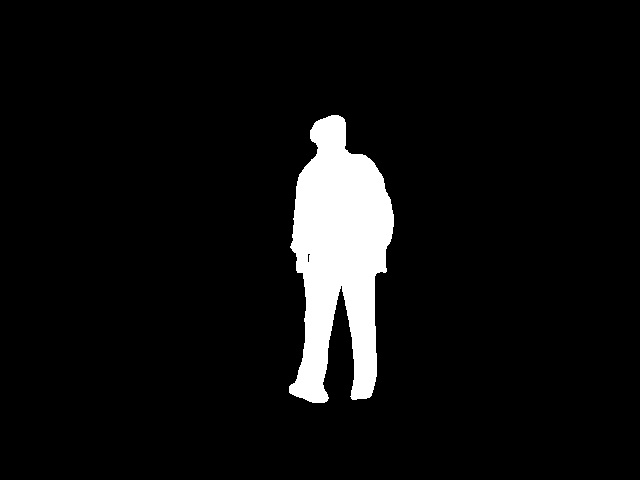

In [1047]:
Image.fromarray(np.array(alpha, dtype=np.uint8))

In [1048]:
# np.unique(alpha)

In [1049]:
import random

In [1050]:
def get_bbox(alpha):
    foreground = alpha > 0.0
    res = None
    res = Image.fromarray(foreground).getbbox()
    if res is None:
        left, upper, right, ylower = 0, 0, alpha.shape[1], alpha.shape[0]
    else:
        left, upper, right, ylower = res
    return (left, upper, right, ylower)

In [1051]:
def draw_bbox(alpha):
    rect = get_bbox(alpha)
    rect_width = rect[2] - rect[0]
    rect_height = rect[3] - rect[1]
    res = cv2.rectangle(np.array(alpha, dtype=np.uint8), rect[:2], rect[2:], color = 128, thickness =2)
    return res

In [1052]:
# res  = draw_bbox(alpha)
# Image.fromarray(np.array(res, dtype=np.uint8))

In [1053]:
def resize_and_crop_by_bbox(alpha, ref_size = 512, random_scale = 1.5):
    rect = get_bbox(alpha)
    rect_width = rect[2] - rect[0]
    rect_height = rect[3] - rect[1]

    im_h, im_w = alpha.shape

    # 将BBOX裁剪出来
    width_pad = int(rect_width / 2.0)
    height_pad = int(rect_height / 2.0)
    pad_for_long_side = max(width_pad, height_pad)
    pad_for_short_side = pad_for_long_side + int(abs(rect_height - rect_width) / 2.0)
    if im_h >= im_w:
        x_start = max(rect[0] - pad_for_short_side, 0)
        x_end = min(rect[2] + pad_for_short_side, im_w - 1)
        y_start = max(rect[1] - pad_for_long_side, 0)
        y_end = min(rect[3] + pad_for_long_side, im_h - 1)
    else:
        x_start = max(rect[0] - pad_for_long_side, 0)
        x_end = min(rect[2] + pad_for_long_side, im_w - 1)
        y_start = max(rect[1] - pad_for_short_side, 0)
        y_end = min(rect[3] + pad_for_short_side, im_h - 1)
    alpha = alpha[y_start:y_end, x_start:x_end, ...]

    # 将短边缩短到512
    im_h, im_w = alpha.shape
    # 非标准512x512图片，resize到短边为ref_size~ref_size*random_scale
    # 然后center crop 或 random crop
    if not (im_h == ref_size and im_w == ref_size):
        random_size = np.random.randint(ref_size, int(ref_size * random_scale))
        if im_w >= im_h:
            im_rh = random_size
            im_rw = int(im_w / im_h * random_size)
        elif im_w < im_h:
            im_rw = random_size
            im_rh = int(im_h / im_w * random_size)

    # img = cv2.resize(img, (im_rw, im_rh), interpolation=cv2.INTER_LINEAR)
    alpha = cv2.resize(alpha, (im_rw, im_rh), interpolation=cv2.INTER_LINEAR)

    # random crop
    x0 = random.randint(0, im_rw - ref_size)
    y0 = random.randint(0, im_rh - ref_size)
    # img = img[y0:y0 + ref_size, x0:x0 + ref_size, ...]
    alpha = alpha[y0:y0 + ref_size, x0:x0 + ref_size]
    
    return alpha

(512, 512)


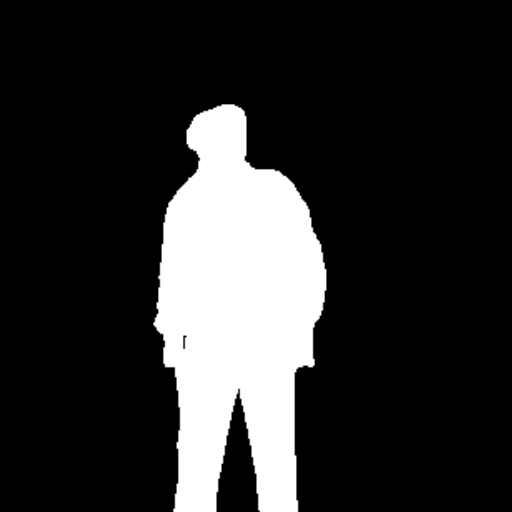

In [1078]:
res = resize_and_crop_by_bbox(alpha)
print(res.shape)
Image.fromarray(np.array(res, dtype=np.uint8))